In [ ]:
%pip install tensorflow==2.8.0
%pip install liac-arff==2.5.0
%pip install pandas==1.4.2
%pip install scikit-learn==1.0.2
%pip install matplotlib==3.5.1
%pip install seaborn==0.11.2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Imports
First we will import required libraries.

- liac-arff is used to process arff files
- matplotlib & seaborn is used to output result graphs
- scikit-learn is used to assist with dataset preparation for machine learning
- tensorflow is used to build, train and test models
- pandas is used to load csv data into a dataframe for in-memory manipulation

In [ ]:
from pathlib import Path
from urllib.request import urlopen

import arff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd

## Variables
Here we will set up some constant variables to be shared with various processes.

In [4]:
DATA_SET_URL = "https://www.openml.org/data/download/1592290/phpgNaXZe"
ARFF_FILE_NAME = "dataset.arff"
CSV_FILE_NAME = "dataset.csv"
CSV_HEADER = "sbp,tobacco,ldl,adiposity,famhist,type,obesity,alcohol,age,chd"

## Download Dataset
First we will need to download the dataset from OpenML. This section of code will download it to write it to disk.

When downloading the dataset a few extra white space characters are added so this code removes any by using the `strip()` function.

Before downloading a check will be run to skip this if the file already exists.

In [5]:
if not Path(ARFF_FILE_NAME).exists():
    with urlopen(DATA_SET_URL) as response:
        content = response.read()
        with open(ARFF_FILE_NAME, "wb") as fo:
            fo.write(content.strip())

## Load Dataset

The following code will load the arff data into memory using the "liac-arff" library. This is required as the data is given as an arff file.

In [6]:
with open(ARFF_FILE_NAME) as fo:
    arff_dataset = arff.load(fo)

## Convert To CSV
To use this dataset with tensorflow we need to convert it to a csv file. This code create a csv file places a predefined header (which matches the attribute names). Then we access the "data" field of the dataset, which is provided as a list which we then join into a string separating each column with a "," and ending each row with "\n", which is the newline character. This csv file will then be written to disk.

Before processing a new csv file; a check will be run to skip this if the file already exists.

In [8]:
if not Path(CSV_FILE_NAME).exists():
    data = arff_dataset["data"]

    with open(CSV_FILE_NAME, "wt") as fo:
        fo.write(CSV_HEADER + "\n")
        for row in data:
            fo.write(",".join([str(col) for col in row]) + "\n")

## Load CSV
To load it into tensorflow we need to read the csv data into a pandas data-frame, this allows for the data to be manipulated in memory easily.

To load the "x" coordinate data, which will be the inputs, we will use pandas `get_dummies()` method, which will convert the data into a format for tensor flow and dropping the output column.

Then we will store the output column as "y" which has the header name of "chd".

In [9]:
df = pd.read_csv(CSV_FILE_NAME)

x = pd.get_dummies(df.drop(['chd'], axis=1))
y = df["chd"]

As our data is now loaded, we can use sklearn's `train_test_split()` method, which will allow us to split our data into two section, one for training and the other for testing. I have selected to keep 20% for testing leaving 80% for training.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

This is a sample output of our training data "x" rows

In [11]:
x_train.head()

,sbp,tobacco,ldl,adiposity,famhist,type,obesity,alcohol,age
282,206.0,0.00,4.17,33.23,2,69.0,27.36,6.17,50.0
105,158.0,3.60,2.97,30.11,2,63.0,26.64,108.00,64.0
288,123.0,0.05,4.61,13.69,2,51.0,23.23,2.78,16.0
327,128.0,0.00,2.98,12.59,2,65.0,20.74,2.06,19.0
376,114.0,3.60,4.16,22.58,2,60.0,24.49,65.31,31.0


This is a sample output of our training data "y" rows.

In [12]:
y_train.head()

282    2
105    1
288    1
327    1
376    1
Name: chd, dtype: int64

## Create Model
Now our data is loaded and processed, we need to make our CNN models. As our dataset is numerical I am using the `Sequential` model from keras.

The first layer of our network will be the input, it will have two nodes as that is the number of classes in our dataset. The number of inputs will match the length of our columns from the dataset.

We will use one hidden layer as we don't have much data, setting that to use sixteen nodes.

The last layer will be our output, because we want a true/false output the number of nodes has been set to one. It will also use a sigmoid function as we want the true/false output.

In [160]:
model = Sequential()
model.add(Dense(units=2, activation='relu', input_dim=len(x_train.columns)))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

Here we compile the model. It will use `binary_crossentropy` for detecting when accuracy has gone down. We will request that metric data for accuracy to be shown during fitting so we can see the progress of the training.

In [161]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics='accuracy')

Here we can see a summary of how our model is constructed.

In [162]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 2)                 20        
                                                                 
 dense_45 (Dense)            (None, 16)                48        
                                                                 
 dense_46 (Dense)            (None, 1)                 17        
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


## Train Model
Here we train the model, specifying that we want twenty epochs as we don't have much data to train with. Multiprocessing is also specified which will allow full utilisation of all CPU cores.

In [163]:
model.fit(x_train, y_train, epochs=20, batch_size=32, use_multiprocessing=True)

Epoch 1/20
12/12 [==============================] - 0s 488us/step - loss: nan - accuracy: 0.5637 
Epoch 2/20
12/12 [==============================] - 0s 461us/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/20
12/12 [==============================] - 0s 426us/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/20
12/12 [==============================] - 0s 465us/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/20
12/12 [==============================] - 0s 486us/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/20
12/12 [==============================] - 0s 439us/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/20
12/12 [==============================] - 0s 478us/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/20
12/12 [==============================] - 0s 492us/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/20
12/12 [==============================] - 0s 433us/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/20
12/12 [==============================] - 0s 458us/step - loss: nan - accuracy: 0.0

## Test Model
Now the model has been trained we can test it using our test data. We will use the `predict()` method to pass in our test data and get out a predication. We will then convert the accuracy values to true/false.

In [171]:
y_predication = model.predict(x_test)
y_predication = [0 if val < 0.5 else 1 for val in y_predication]

## Calculate Accuracy

In [172]:
accuracy = accuracy_score(y_test, y_predication)

print(round(accuracy * 100, 4), "% Accurate")

66.6667 % Accurate


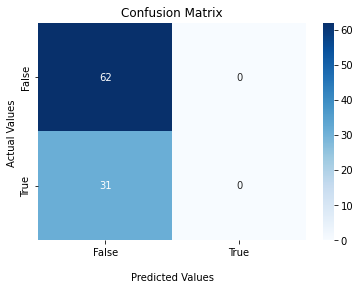

In [173]:
confusion = confusion_matrix(y_test, y_predication)

ax = sns.heatmap(confusion, annot=True, cmap='Blues')
ax.set_title("Confusion Matrix")
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()